In [ ]:
import gc

In [ ]:
%%capture
%pip install dask[dataframe]
%pip install memory_profiler

In [ ]:
from google.colab import drive
import pandas as pd

# Step 1: Mount Google Drive
drive.mount('/content/drive')




Mounted at /content/drive


In [ ]:
# # Get categorical columns
# categorical_columns = train1.select_dtypes(include=['object', 'category']).columns

# # Drop 'col_125' if it exists
# if 'col_125' in train1.columns:
#     train1.drop('col_125', axis=1,inplace=True)

# print(categorical_columns)


In [ ]:
import pandas as pd
from sklearn.model_selection import train_test_split

# Load the data with the first 1000 rows
train1 = pd.read_csv("/content/drive/MyDrive/train_1.csv", nrows=2000)
train2_1 = pd.read_csv("/content/drive/MyDrive/train_2_1.csv", nrows=2000)
train2_2 = pd.read_csv("/content/drive/MyDrive/train_2_2.csv", nrows=2000)

# Split each dataset into train and test (80% train, 20% test)
train_df, test_df = train_test_split(train1, test_size=0.2, random_state=42)
train2_1_df, test2_1_df = train_test_split(train2_1, test_size=0.2, random_state=42)
train2_2_df, test2_2_df = train_test_split(train2_2, test_size=0.2, random_state=42)

# Display the shapes of each component to verify
print("train_df:", train_df.shape, "test_df:", test_df.shape)
print("train2_1_df:", train2_1_df.shape, "test2_1_df:", test2_1_df.shape)
print("train2_2_df:", train2_2_df.shape, "test2_2_df:", test2_2_df.shape)


In [ ]:
#@title Proess Train and test data

import pandas as pd
import numpy as np
from typing import Dict, List, Tuple
import gc

class DataProcessor:
    def __init__(self):
        self.encoders: Dict = {}
        self.categorical_columns = [
            'prod', 'col_114', 'col_117', 'col_118', 'col_123',
            'col_140', 'col_150', 'col_156', 'col_157', 'col_158', 'col_161', 'col_148'
        ]
        self.cols_to_drop = [f'add_{i}' for i in [431, 671, 672, 673, 675, 676, 677]]

    def calculate_means_for_duplicates(self, df: pd.DataFrame, suffix: str) -> pd.DataFrame:
        """Calculate means for each unique ID in the additional data"""
        # Drop unnecessary columns
        df = df.drop(columns=[col for col in self.cols_to_drop if col in df.columns])

        # Get numeric columns
        numeric_cols = df.select_dtypes(exclude=['object']).columns

        # Group by ID and calculate means
        means_df = df.groupby('id')[numeric_cols].mean().reset_index()

        # Add suffix to column names except 'id'
        rename_dict = {col: f"{col}{suffix}" for col in means_df.columns if col != 'id'}
        means_df = means_df.rename(columns=rename_dict)

        del df
        gc.collect()

        return means_df

    def encode_categorical(self, df: pd.DataFrame, is_training: bool = True) -> pd.DataFrame:
        """
        Encode categorical columns.
        During training, create encodings; during testing, use existing encodings.
        """
        for col in self.categorical_columns:
            if col in df.columns:
                if is_training:
                    # During training, create new encodings
                    unique_values = df[col].unique()
                    self.encoders[col] = {val: idx + 1 for idx, val in enumerate(unique_values)}

                # Transform values using encodings (same for both train and test)
                df[col] = (
                    df[col]
                    .map(self.encoders.get(col, {}))
                    .fillna(0)
                    .astype('int32')
                )
        return df

    def process_special_columns(self, df: pd.DataFrame) -> pd.DataFrame:
        """Process special columns that need specific handling"""
        if 'col_116' in df.columns:
            df['col_116'] = pd.to_numeric(df['col_116'], errors='coerce').fillna(0).astype('float32')

        if 'col_125' in df.columns:
            df['col_125_NR'] = (df['col_125'] == 'NR').astype('int8')
            df['col_125_numeric'] = (
                pd.to_numeric(df['col_125'].replace('NR', np.nan), errors='coerce')
                .fillna(0)
                .astype('float32')
            )
            df = df.drop('col_125', axis=1)

        return df

    def fit_transform(self, train_df: pd.DataFrame, train2_1: pd.DataFrame, train2_2: pd.DataFrame) -> pd.DataFrame:
        """
        Process training data:
        1. Calculate means for additional training data independently
        2. Create categorical encodings
        3. Process special columns
        """
        # Calculate means for additional training data
        print("Processing train2_1...")
        train2_1_means = self.calculate_means_for_duplicates(train2_1.copy(), '_21')
        print("Processing train2_2...")
        train2_2_means = self.calculate_means_for_duplicates(train2_2.copy(), '_22')

        # Merge all training dataframes
        print("Merging training dataframes...")
        merged_df = (train_df.merge(train2_1_means, on='id', how='left')
                           .merge(train2_2_means, on='id', how='left'))

        # Fill missing values for numeric columns
        numeric_cols = merged_df.select_dtypes(include=['float32', 'float64', 'int32', 'int64']).columns
        merged_df[numeric_cols] = merged_df[numeric_cols].fillna(0)

        # Create encodings and transform categorical columns
        print("Processing categorical columns...")
        merged_df = self.encode_categorical(merged_df, is_training=True)

        # Process special columns
        merged_df = self.process_special_columns(merged_df)

        return merged_df

    def transform(self, test_df: pd.DataFrame, test2_1: pd.DataFrame, test2_2: pd.DataFrame) -> pd.DataFrame:
        """
        Process test data:
        1. Calculate means for additional test data independently
        2. Use existing categorical encodings
        3. Process special columns
        """
        # Calculate means for additional test data
        print("Processing test2_1...")
        test2_1_means = self.calculate_means_for_duplicates(test2_1.copy(), '_21')
        print("Processing test2_2...")
        test2_2_means = self.calculate_means_for_duplicates(test2_2.copy(), '_22')

        # Merge all test dataframes
        print("Merging test dataframes...")
        merged_df = (test_df.merge(test2_1_means, on='id', how='left')
                          .merge(test2_2_means, on='id', how='left'))

        # Fill missing values for numeric columns
        numeric_cols = merged_df.select_dtypes(include=['float32', 'float64', 'int32', 'int64']).columns
        merged_df[numeric_cols] = merged_df[numeric_cols].fillna(0)

        # Transform categorical columns using existing encodings
        print("Processing categorical columns...")
        merged_df = self.encode_categorical(merged_df, is_training=False)

        # Process special columns
        merged_df = self.process_special_columns(merged_df)

        return merged_df

# Usage example:
processor = DataProcessor()

# First process training data to create encodings
df_train = processor.fit_transform(train_df, train2_1_df, train2_2_df)

# Then process test data using the same encodings
df_test = processor.transform(test_df, test2_1_df, test2_2_df)

In [ ]:
df_train.shape,df_test.shape

In [ ]:
import psutil

# Current memory usage in MB
used_memory = psutil.Process().memory_info().rss / 1024 / 1024

# Total RAM in MB (12.7 GB = 12.7 * 1024 MB)
total_memory = 12.7 * 1024

# Calculate percentage usage
percentage_usage = (used_memory / total_memory) * 100

print(f"Current memory usage: {used_memory:.2f} MB")
print(f"Percentage of total RAM used: {percentage_usage:.2f}%")


In [ ]:
import pandas as pd

def process_dataframe(df: pd.DataFrame) -> pd.DataFrame:
    """
    Process the given DataFrame by:
    1. Extracting categorical columns.
    2. Dropping 'col_125' if it exists.

    Args:
        df (pd.DataFrame): The input DataFrame to process.

    Returns:
        pd.DataFrame: The processed DataFrame.
    """
    # Extract categorical columns
    categorical_columns = df.select_dtypes(include=['object', 'category']).columns

    # Drop 'col_125' if it exists
    if 'col_125' in df.columns:
        df.drop('col_125', axis=1, inplace=True)

    print("Categorical Columns:", categorical_columns)
    return df


df_train = process_dataframe(df_train)
df_test = process_dataframe(df_test)


In [ ]:
import pandas as pd
import numpy as np
import gc
from typing import List, Tuple, Optional
import psutil
import os
import time
from memory_profiler import profile

class FeatureDifferenceCreator:
    def __init__(self, batch_size: int = 1000):
        """
        Initialize the feature difference creator.

        Args:
            batch_size: Number of columns to process at once
        """
        self.batch_size = batch_size

    def _get_column_pairs(self, df: pd.DataFrame) -> List[Tuple[str, str]]:
        """Get pairs of columns to calculate differences."""
        cols_21 = [col for col in df.columns if col.endswith('_21') and col != 'col_21']
        column_pairs = []

        for col_21 in cols_21:
            col_22 = col_21.replace('_21', '_22')
            if col_22 in df.columns:
                column_pairs.append((col_21, col_22))

        return column_pairs

    def _create_batch_differences(self,
                                  df: pd.DataFrame,
                                  column_pairs: List[Tuple[str, str]],
                                  drop_original: bool = True) -> Tuple[pd.DataFrame, List[str]]:
        """Create differences for a batch of columns."""
        diff_data = {}
        cols_to_drop = []

        for col_21, col_22 in column_pairs:
            diff_col = col_21.replace('_21', '_diff')
            diff_data[diff_col] = df[col_22] - df[col_21]

            if drop_original:
                cols_to_drop.extend([col_21, col_22])

        return pd.DataFrame(diff_data), cols_to_drop

    @profile
    def create_difference_features(self,
                                   df: pd.DataFrame,
                                   drop_original: bool = True) -> pd.DataFrame:
        """
        Create difference features using pandas with memory efficiency.

        Args:
            df: Input dataframe
            drop_original: Whether to drop original columns

        Returns:
            DataFrame with difference features
        """
        # Get column pairs for differences
        column_pairs = self._get_column_pairs(df)

        # Process in batches
        all_diffs = []
        all_cols_to_drop = []

        for i in range(0, len(column_pairs), self.batch_size):
            batch_pairs = column_pairs[i:i + self.batch_size]

            # Create differences for current batch
            batch_diffs, cols_to_drop = self._create_batch_differences(
                df, batch_pairs, drop_original
            )

            all_diffs.append(batch_diffs)
            all_cols_to_drop.extend(cols_to_drop)

            # Clear memory
            gc.collect()

        # Combine all differences
        if all_diffs:
            # Drop original columns if requested
            if drop_original:
              print("orignal_cols not dropped")
                # df = df.drop(columns=all_cols_to_drop)

            # Concatenate all differences
            result = pd.concat([df] + all_diffs, axis=1)
        else:
            result = df

        # Clear memory
        del all_diffs, df
        gc.collect()

        return result

class PerformanceMonitor:
    @staticmethod
    def get_memory_usage() -> float:
        """Get current memory usage in MB."""
        process = psutil.Process(os.getpid())
        return process.memory_info().rss / 1024 / 1024

    @staticmethod
    def monitor_performance(func):
        """Decorator to monitor performance of a function."""
        def wrapper(*args, **kwargs):
            start_time = time.time()
            initial_memory = PerformanceMonitor.get_memory_usage()
            print(f"Initial memory usage: {initial_memory:.2f} MB")

            try:
                result = func(*args, **kwargs)

                end_time = time.time()
                final_memory = PerformanceMonitor.get_memory_usage()

                print(f"\nPerformance Metrics:")
                print(f"Final memory usage: {final_memory:.2f} MB")
                print(f"Memory change: {final_memory - initial_memory:.2f} MB")
                print(f"Processing time: {end_time - start_time:.2f} seconds")
                print(f"Final dataframe shape: {result.shape}")

                return result

            except Exception as e:
                print(f"Error occurred: {str(e)}")
                return None

        return wrapper

def process_with_monitoring(df: pd.DataFrame,
                            batch_size: int = 1000) -> Optional[pd.DataFrame]:
    """
    Process dataframe with performance monitoring.

    Args:
        df: Input dataframe
        batch_size: Number of columns to process at once

    Returns:
        Processed dataframe or None if error occurs
    """
    creator = FeatureDifferenceCreator(batch_size)

    @PerformanceMonitor.monitor_performance
    def process():
        return creator.create_difference_features(df)

    return process()

# Example usage:
# Initialize with custom settings
creator = FeatureDifferenceCreator(batch_size=1000)

# # Process with monitoring
# processed_df = process_with_monitoring(df=your_dataframe, batch_size=1000)

# Or process directly
df_train = creator.create_difference_features(df_train)
df_test = creator.create_difference_features(df_test)

In [ ]:
df_train.shape,df_test.shape

In [ ]:
df_train.fillna(0, inplace=True)
df_test.fillna(0, inplace=True)



In [ ]:
df_train.hist('label')

In [ ]:
import psutil

# Current memory usage in MB
used_memory = psutil.Process().memory_info().rss / 1024 / 1024

# Total RAM in MB (12.7 GB = 12.7 * 1024 MB)
total_memory = 12.7 * 1024

# Calculate percentage usage
percentage_usage = (used_memory / total_memory) * 100

print(f"Current memory usage: {used_memory:.2f} MB")
print(f"Percentage of total RAM used: {percentage_usage:.2f}%")


In [ ]:
import pandas as pd
import numpy as np
from imblearn.combine import SMOTETomek
from sklearn.model_selection import train_test_split
import gc

# Memory optimization function
def reduce_mem_usage(df):
    start_mem = df.memory_usage().sum() / 1024**2
    for col in df.columns:
        col_type = df[col].dtype

        if col_type != object:
            c_min = df[col].min()
            c_max = df[col].max()
            if str(col_type)[:3] == 'int':
                if c_min > np.iinfo(np.int8).min and c_max < np.iinfo(np.int8).max:
                    df[col] = df[col].astype(np.int8)
                elif c_min > np.iinfo(np.int16).min and c_max < np.iinfo(np.int16).max:
                    df[col] = df[col].astype(np.int16)
                elif c_min > np.iinfo(np.int32).min and c_max < np.iinfo(np.int32).max:
                    df[col] = df[col].astype(np.int32)
                elif c_min > np.iinfo(np.int64).min and c_max < np.iinfo(np.int64).max:
                    df[col] = df[col].astype(np.int64)
            else:
                if c_min > np.finfo(np.float16).min and c_max < np.finfo(np.float16).max:
                    df[col] = df[col].astype(np.float16)
                elif c_min > np.finfo(np.float32).min and c_max < np.finfo(np.float32).max:
                    df[col] = df[col].astype(np.float32)
                else:
                    df[col] = df[col].astype(np.float64)

    end_mem = df.memory_usage().sum() / 1024**2
    print(f'Memory usage decreased from {start_mem:.2f} MB to {end_mem:.2f} MB ({100 * (start_mem - end_mem) / start_mem:.1f}% reduction)')
    return df

# Optimize memory usage
df_train = reduce_mem_usage(df_train)
df_test = reduce_mem_usage(df_test)

# Separate features and target
X = df_train.drop(['label','loan_id','id'], axis=1)
y = df_train['label']

del df_train
gc.collect()

# Print initial class distribution
print("Initial class distribution:")
print(y.value_counts(normalize=True))

# # Split the data
# X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

# # Free up memory
# del X, y
# gc.collect()

# Apply SMOTETomek
print("Applying SMOTETomek...")
smotetomek = SMOTETomek(sampling_strategy='auto', random_state=42)
X_resampled, y_resampled = smotetomek.fit_resample(X, y)

# Free up memory
del X, y
gc.collect()

# Print resampled class distribution
print("\nResampled class distribution:")
print(pd.Series(y_resampled).value_counts(normalize=True))

# Print shape of resampled data
print(f"\nShape of resampled features: {X_resampled.shape}")
print(f"Shape of resampled labels: {y_resampled.shape}")


X_resampled_df = pd.DataFrame(X_resampled, columns=X_resampled.columns)
y_resampled_df = pd.Series(y_resampled, name='label')

# Combine features and label into a single DataFrame
df_train_resampled = pd.concat([X_resampled_df, y_resampled_df], axis=1)

# # Optimize memory usage of resampled data
# resampled_df = reduce_mem_usage(resampled_df)

del X_resampled,y_resampled
gc.collect()

# # Print final memory usage
# print(f"\nFinal memory usage of resampled data: {resampled_df.memory_usage().sum() / 1024**2:.2f} MB")

# # Don't forget to keep your test set separate
# print(f"\nShape of test set: {X_test.shape}")

In [ ]:
df_train_resampled.hist('label')

In [ ]:
df_train_resampled.shape,df_test.shape

In [ ]:
import pandas as pd
import numpy as np

def remove_correlated_features(df, threshold=0.95):
    """
    Removes one of the pair of features with correlation >= threshold.

    Parameters:
    df (pandas.DataFrame): The input DataFrame.
    threshold (float): The correlation threshold above which a feature will be removed.

    Returns:
    pandas.DataFrame: The DataFrame with highly correlated features removed.
    """
    corr_matrix = df.corr().abs()
    upper = corr_matrix.where(np.triu(np.ones(corr_matrix.shape), k=1).astype(bool))
    to_drop = [column for column in upper.columns if any(upper[column] > threshold)]
    del upper,corr_matrix
    gc.collect

    print(f"Removing {len(to_drop)} features:")




    return df.drop(to_drop, axis=1),to_drop

In [ ]:
from sklearn.feature_selection import mutual_info_classif

def get_mutual_information(df_train_resampled):
    """
    Calculates the mutual information between each feature and the target variable.

    Parameters:
    X (pandas.DataFrame): The feature matrix.
    y (pandas.Series): The target variable.

    Returns:
    pandas.Series: A Series containing the mutual information for each feature.
    """
    X = df_train_resampled.drop('label', axis=1)
    y = df_train_resampled['label']
    mutual_info = mutual_info_classif(X, y)
    feature_mutual_info = pd.Series(mutual_info, index=X.columns)
    feature_mutual_info = feature_mutual_info.sort_values(ascending=False)

    return feature_mutual_info

In [ ]:
from sklearn.ensemble import RandomForestClassifier

def get_feature_importance(X, y):
    """
    Calculates the feature importance scores using a Random Forest Classifier.

    Parameters:
    X (pandas.DataFrame): The feature matrix.
    y (pandas.Series): The target variable.

    Returns:
    pandas.Series: A Series containing the feature importance scores.
    """
    # Train a Random Forest Classifier
    rf = RandomForestClassifier(random_state=42)
    rf.fit(X, y)

    # Get the feature importance scores
    feature_importance = pd.Series(rf.feature_importances_, index=X.columns)

    # Sort the feature importance scores in descending order
    feature_importance = feature_importance.sort_values(ascending=False)

    return feature_importance


In [ ]:
# Remove highly correlated features
df_train_resampled,to_drop = remove_correlated_features(df_train_resampled, threshold=0.91)



In [ ]:


# Calculate mutual information for each feature

feature_mutual_info = get_mutual_information(df_train_resampled)

print("Feature Mutual Information:")
print(feature_mutual_info)

In [ ]:
fimp=(feature_mutual_info)
# Assuming 'fimp' is your Feature Mutual Information Series
zero_importance_count = (fimp==0).sum()

print(f"Number of columns with zero importance: {zero_importance_count}")



In [ ]:
# Remove features with mutual information score of 0
df_train_resampled = df_train_resampled.drop(feature_mutual_info[feature_mutual_info == 0].index, axis=1)

print("Processed DataFrame shape after removing zero-importance features:")
print(df_train_resampled.shape)

In [ ]:

# Calculate feature importance using Random Forest
feature_importance = get_feature_importance(df_train_resampled.drop('label', axis=1), df_train_resampled['label'])

print("Feature Importance Scores:")
print(feature_importance)

In [ ]:
# Extract the first 20 feature names (keys)
top_20_features = list(feature_importance.keys())[:20]

print(top_20_features)


In [ ]:
fimp=(feature_importance)
# Assuming 'fimp' is your Feature Mutual Information Series
zero_importance_count = (fimp==0).sum()

print(f"Number of columns with zero importance: {zero_importance_count}")



In [ ]:
# Remove features with mutual information score of 0
df_train_resampled = df_train_resampled.drop(feature_importance[feature_importance == 0].index, axis=1)


In [ ]:
df_train_resampled.shape

In [ ]:
ids_df = pd.DataFrame({
    'loan_id': df_test['loan_id'],
    'id': df_test['id']
})


In [ ]:
df_test.drop(['loan_id', 'id'], axis=1, inplace=True)


In [ ]:
df_test.drop(to_drop, axis=1, inplace=True)


In [ ]:
df_test = df_test.drop(feature_mutual_info[feature_mutual_info == 0].index, axis=1, errors='ignore')



In [ ]:
df_test = df_test.drop(feature_importance[feature_importance == 0].index, axis=1)

In [ ]:
df_test.shape,df_train_resampled.shape


In [ ]:
%%capture
# %pip install optuna
%pip install catboost


In [ ]:
df_train_resampled.shape,df_test.shape


In [ ]:
df_train=pd.read_csv("/content/drive/MyDrive/df_train_resampled2.csv")

In [ ]:
top_20_columns=['col_76', 'col_24', 'col_75', 'col_39', 'col_87', 'col_126', 'col_79', 'col_66', 'col_116', 'col_37', 'col_59', 'col_152', 'col_74', 'col_72', 'col_7', 'col_162', 'col_6', 'col_119', 'col_12', 'col_21']

In [ ]:
# 1. First split into train and test with real-world distribution
train_df=df_train[:20000]
X = train_df.drop('label', axis=1)
y = train_df['label']

X_train, X_test, y_train, y_test = train_test_split(
    X, y,
    test_size=0.2,
    random_state=42,
    stratify=None  # Don't stratify to maintain real distribution in test
)

# 2. Then balance only the training data
train_df = pd.concat([X_train, y_train], axis=1)
train_0 = train_df[train_df['label'] == 0]
train_1 = train_df[train_df['label'] == 1]

# Sample equal numbers for training only
n_samples = min(len(train_0), len(train_1))
train_0_balanced = train_0.sample(n=n_samples, random_state=42)
train_1_balanced = train_1.sample(n=n_samples, random_state=42)

# Create balanced training set
train_balanced = pd.concat([train_0_balanced, train_1_balanced])
train_balanced = train_balanced.sample(frac=1, random_state=42)

# Split features and target for training
X_train = train_balanced.drop('label', axis=1)
y_train = train_balanced['label']

# Keep test set as is (imbalanced)
X_test = X_test
y_test = y_test

# Train and evaluate
rf = RandomForestClassifier(n_estimators=100, random_state=42)
rf.fit(X_train_balanced, y_train_balanced)
y_probs = rf.predict_proba(X_test)[:, 1]
roc_auc = roc_auc_score(y_test, y_probs)

print(f'ROC AUC Score: {roc_auc:.4f}')
print(f'\nTest set distribution:')
print(y_test.value_counts(normalize=True))

ROC AUC Score: 0.7900

Test set distribution:
label
0    0.90975
1    0.09025
Name: proportion, dtype: float64


In [ ]:
from sklearn.preprocessing import RobustScaler, PowerTransformer
import pandas as pd

def apply_robust_scaling(X_train, X_test):
    """
    Apply robust scaling to train and test data.

    Parameters:
    X_train (pd.DataFrame): Training features
    X_test (pd.DataFrame): Test features

    Returns:
    tuple: (scaled_train_df, scaled_test_df)
    """
    scaler = RobustScaler()

    # Fit on train, transform both
    X_train_scaled = scaler.fit_transform(X_train)
    X_test_scaled = scaler.transform(X_test)

    return X_train_scaled, X_test_scaled

def transform_important_features(top_features, df_train, df_test):
    """
    Apply Yeo-Johnson transformation to specified features.

    Parameters:
    top_features (list): List of feature names to transform
    df_train (pd.DataFrame): Training data
    df_test (pd.DataFrame): Test data

    Returns:
    tuple: (transformed_train_df, transformed_test_df)
    """
    train_df = df_train.copy()
    test_df = df_test.copy()

    for feature in top_features:
        if feature in train_df.columns:
            try:
                transformer = PowerTransformer(method='yeo-johnson', standardize=False)

                # Fit on train, transform both
                train_df[feature] = transformer.fit_transform(
                    train_df[feature].values.reshape(-1, 1)
                ).ravel()

                test_df[feature] = transformer.transform(
                    test_df[feature].values.reshape(-1, 1)
                ).ravel()

            except Exception as e:
                print(f"Warning: Could not transform {feature}. Error: {str(e)}")
                continue

    return train_df, test_df

# Usage example:
# Ensure that X_train and X_test are defined before applying the scaling
X_train, X_test = apply_robust_scaling(X_train, X_test)


X_train, X_test = transform_important_features(
    top_20_columns,
    pd.DataFrame(X_train),  # Convert scaled data back to DataFrame
    pd.DataFrame(X_test)
)


In [ ]:
%%capture
%pip install catboost
%pip install  optuna

                group  total_importance
0  First 650 Features          0.956598
1  Remaining Features          0.024085


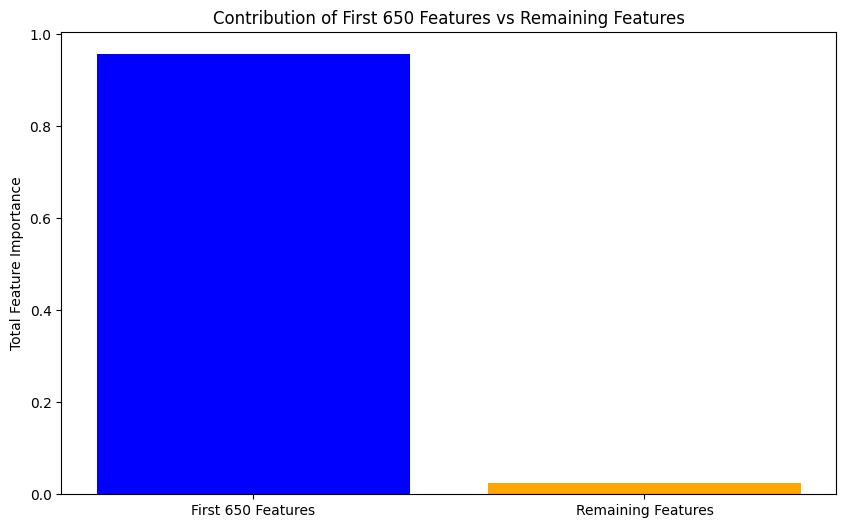

In [ ]:
from sklearn.ensemble import RandomForestClassifier
import pandas as pd
import numpy as np


# # Train the Random Forest model
# model = RandomForestClassifier(random_state=42)
# model.fit(X_train, y_train)
model=rf

# Get feature importances
importances = model.feature_importances_

# Create a DataFrame to hold feature names and their importances
feature_importance_df = pd.DataFrame({
    'feature': X_train.columns,
    'importance': importances
})

# Sort by importance
feature_importance_df.sort_values(by='importance', ascending=False, inplace=True)

# Separate the first 100 features and the rest
first_100_features = feature_importance_df.head(600)
remaining_features = feature_importance_df.iloc[650:]

# Calculate total importance for first 100 features and remaining features
first_100_importance_sum = first_100_features['importance'].sum()
remaining_importance_sum = remaining_features['importance'].sum()

# Create a summary DataFrame
summary_df = pd.DataFrame({
    'group': ['First 650 Features', 'Remaining Features'],
    'total_importance': [first_100_importance_sum, remaining_importance_sum],
})

print(summary_df)

# Optional: Plotting the feature importances
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 6))
plt.bar(summary_df['group'], summary_df['total_importance'], color=['blue', 'orange'])
plt.title('Contribution of First 650 Features vs Remaining Features')
plt.ylabel('Total Feature Importance')
plt.show()


Training and evaluating base models...

Training Random Forest...

Training LightGBM...
[LightGBM] [Info] Number of positive: 1366, number of negative: 14634
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.086989 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 101160
[LightGBM] [Info] Number of data points in the train set: 16000, number of used features: 784
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.085375 -> initscore=-2.371461
[LightGBM] [Info] Start training from score -2.371461

Training XGBoost...

Training CatBoost...

Training AdaBoost...
Training stacked ensemble...

Training Stacked Ensemble...

=== Model Performance Comparison ===

Base Models Performance:
        Model  ROC AUC  Accuracy
     CatBoost 0.832382   0.91350
     LightGBM 0.828995   0.91175
      XGBoost 0.809743   0.90600
     AdaBoost 0.808869   0.90900

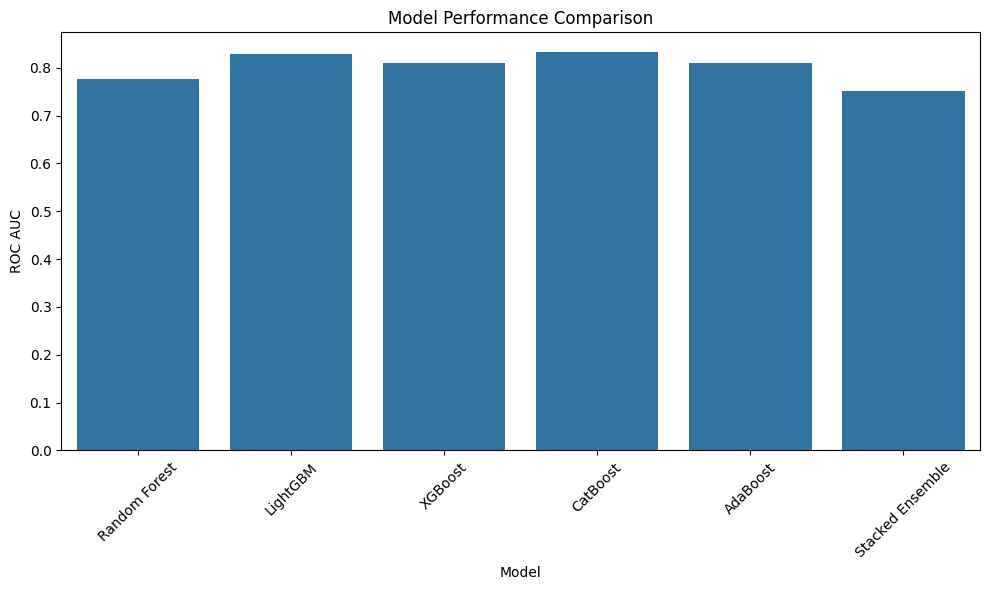

In [ ]:
import pandas as pd
import numpy as np
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier, ExtraTreesRegressor
from sklearn.metrics import roc_auc_score, accuracy_score, classification_report, confusion_matrix
from lightgbm import LGBMClassifier
from xgboost import XGBClassifier
from catboost import CatBoostClassifier
import optuna
from sklearn.model_selection import cross_val_score
import seaborn as sns
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings('ignore')

class ModelEvaluator:
    def __init__(self, random_state=42):
        self.random_state = random_state
        self.base_models = {}
        self.model_scores = {}
        self.model_predictions = {}
        self.detailed_metrics = {}
        self.top_models = []
        self.meta_model = None
        self.top_k = 3

    def train_base_models(self, X_train, X_test, y_train, y_test):
        # Initialize base models
        models = {
            'Random Forest': RandomForestClassifier(n_estimators=200, random_state=self.random_state),
            'LightGBM': LGBMClassifier(random_state=self.random_state),
            'XGBoost': XGBClassifier(random_state=self.random_state),
            'CatBoost': CatBoostClassifier(random_state=self.random_state, verbose=False),
            'AdaBoost': AdaBoostClassifier(random_state=self.random_state),
            # 'ExtraTrees': ExtraTreesRegressor(random_state=self.random_state)
        }

        # Train and evaluate each model
        results = []
        for name, model in models.items():
            print(f"\nTraining {name}...")
            model.fit(X_train, y_train)

            # Get predictions
            y_pred_proba = model.predict_proba(X_test)[:, 1]
            y_pred = (y_pred_proba >= 0.5).astype(int)

            # Calculate metrics
            roc_auc = roc_auc_score(y_test, y_pred_proba)
            accuracy = accuracy_score(y_test, y_pred)

            # Store model and results
            self.base_models[name] = model
            self.model_predictions[name] = y_pred_proba
            self.model_scores[name] = roc_auc

            # Store detailed metrics
            self.detailed_metrics[name] = {
                'ROC AUC': roc_auc,
                'Accuracy': accuracy,
                'Classification Report': classification_report(y_test, y_pred),
                'Confusion Matrix': confusion_matrix(y_test, y_pred)
            }

            results.append({
                'Model': name,
                'ROC AUC': roc_auc,
                'Accuracy': accuracy
            })

        # Create performance comparison DataFrame
        self.performance_df = pd.DataFrame(results).sort_values('ROC AUC', ascending=False)

        # Select top k models for stacking
        self.top_models = self.performance_df.head(self.top_k)['Model'].tolist()
        self.meta_model = self.base_models[self.top_models[0]]

        return self.performance_df

    def train_stacked_ensemble(self, X_train, X_test, y_train, y_test):
        print("\nTraining Stacked Ensemble...")

        # Create stacked features for training
        stacked_train = np.column_stack([
            self.base_models[model].predict_proba(X_train)[:, 1]
            for model in self.top_models
        ])

        # Create stacked features for testing
        stacked_test = np.column_stack([
            self.base_models[model].predict_proba(X_test)[:, 1]
            for model in self.top_models
        ])

        # Train meta-model
        self.meta_model.fit(stacked_train, y_train)

        # Get predictions
        ensemble_pred_proba = self.meta_model.predict_proba(stacked_test)[:, 1]
        ensemble_pred = (ensemble_pred_proba >= 0.5).astype(int)

        # Calculate metrics
        ensemble_roc_auc = roc_auc_score(y_test, ensemble_pred_proba)
        ensemble_accuracy = accuracy_score(y_test, ensemble_pred)

        # Store ensemble results
        self.detailed_metrics['Stacked Ensemble'] = {
            'ROC AUC': ensemble_roc_auc,
            'Accuracy': ensemble_accuracy,
            'Classification Report': classification_report(y_test, ensemble_pred),
            'Confusion Matrix': confusion_matrix(y_test, ensemble_pred)
        }

        return {
            'ROC AUC': ensemble_roc_auc,
            'Accuracy': ensemble_accuracy
        }

    def display_results(self):
        """Display comprehensive results of all models and ensemble"""
        print("\n=== Model Performance Comparison ===")
        print("\nBase Models Performance:")
        print(self.performance_df.to_string(index=False))

        print("\nTop 3 Models Selected for Stacking:")
        for model in self.top_models:
            print(f"- {model}: ROC AUC = {self.model_scores[model]:.4f}")

        print("\nStacked Ensemble Performance:")
        ensemble_metrics = self.detailed_metrics['Stacked Ensemble']
        print(f"ROC AUC: {ensemble_metrics['ROC AUC']:.4f}")
        print(f"Accuracy: {ensemble_metrics['Accuracy']:.4f}")

        print("\nDetailed Classification Report for Best Model:")
        best_model = self.performance_df.iloc[0]['Model']
        print(f"\nBest Model: {best_model}")
        print(self.detailed_metrics[best_model]['Classification Report'])

        # Plot model comparison
        plt.figure(figsize=(10, 6))
        metrics_df = pd.DataFrame({
            'Model': list(self.detailed_metrics.keys()),
            'ROC AUC': [m['ROC AUC'] for m in self.detailed_metrics.values()]
        })
        sns.barplot(data=metrics_df, x='Model', y='ROC AUC')
        plt.xticks(rotation=45)
        plt.title('Model Performance Comparison')
        plt.tight_layout()
        plt.show()

def run_evaluation(X_train, X_test, y_train, y_test):
    """Run complete evaluation pipeline"""
    evaluator = ModelEvaluator()

    # Train and evaluate base models
    print("Training and evaluating base models...")
    evaluator.train_base_models(X_train, X_test, y_train, y_test)

    # Train and evaluate stacked ensemble
    print("Training stacked ensemble...")
    evaluator.train_stacked_ensemble(X_train, X_test, y_train, y_test)

    # Display comprehensive results
    evaluator.display_results()

    return evaluator

# Example usage:
evaluator = run_evaluation(X_train, X_test, y_train, y_test)


In [ ]:
import optuna
from catboost import CatBoostClassifier, Pool
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import roc_auc_score
import numpy as np
import pandas as pd
from functools import partial
import warnings
warnings.filterwarnings('ignore')

def create_pool(X, y=None, cat_features=None):
    """Create CatBoost Pool with optional categorical features"""
    return Pool(X, y, cat_features=cat_features)

def objective(trial, X, y, n_folds=3):
    """
    Optuna objective function for CatBoost optimization.
    Using smaller n_folds (3) for speed while maintaining reliability.
    """
    # Define parameter search space
    param = {
        # Learning parameters (most important)
        'learning_rate': trial.suggest_float('learning_rate', 0.01, 0.3, log=True),
        'depth': trial.suggest_int('depth', 4, 8),  # Restricted depth for speed

        # Tree parameters
        'l2_leaf_reg': trial.suggest_float('l2_leaf_reg', 1e-8, 10.0, log=True),
        'min_child_samples': trial.suggest_int('min_child_samples', 5, 100),

        # Sampling parameters
        'subsample': trial.suggest_float('subsample', 0.5, 1.0),
        'colsample_bylevel': trial.suggest_float('colsample_bylevel', 0.5, 1.0),

        # Fixed parameters for speed
        'iterations': 1000,  # Will use early stopping
        'early_stopping_rounds': 50,
        'random_seed': 42,
        'verbose': 0,
        'task_type': 'CPU',  # Change to 'GPU' if available

        # Specific for imbalanced data
        'auto_class_weights': 'Balanced'
    }

    # Cross-validation using StratifiedKFold
    skf = StratifiedKFold(n_splits=n_folds, shuffle=True, random_state=42)
    scores = []

    # Perform cross-validation
    for fold, (train_idx, val_idx) in enumerate(skf.split(X, y)):
        X_train, X_val = X.iloc[train_idx], X.iloc[val_idx]
        y_train, y_val = y.iloc[train_idx], y.iloc[val_idx]

        # Create CatBoost pools
        train_pool = create_pool(X_train, y_train)
        val_pool = create_pool(X_val, y_val)

        # Initialize and train model
        model = CatBoostClassifier(**param)
        model.fit(
            train_pool,
            eval_set=val_pool,
            use_best_model=True,
            plot=False
        )

        # Predict and evaluate
        y_pred = model.predict_proba(X_val)[:, 1]
        fold_score = roc_auc_score(y_val, y_pred)
        scores.append(fold_score)

        # Prune unpromising trials
        trial.report(fold_score, fold)
        if trial.should_prune():
            raise optuna.TrialPruned()

    return np.mean(scores)

def optimize_catboost(X, y, n_trials=50, timeout=3600):
    """
    Optimize CatBoost hyperparameters using Optuna.

    Parameters:
    -----------
    X : pandas DataFrame
        Features
    y : pandas Series
        Target variable
    n_trials : int
        Number of optimization trials
    timeout : int
        Maximum optimization time in seconds

    Returns:
    --------
    best_params : dict
        Best hyperparameters found
    study : optuna.study.Study
        Completed Optuna study object
    """
    # Create study object with pruner
    pruner = optuna.pruners.MedianPruner(
        n_startup_trials=5,
        n_warmup_steps=10,
        interval_steps=3
    )

    study = optuna.create_study(
        direction='maximize',
        pruner=pruner,
        study_name='catboost_optimization'
    )

    # Optimize with timeout
    study.optimize(
        func=partial(objective, X=X, y=y),
        n_trials=n_trials,
        timeout=timeout,
        show_progress_bar=True
    )

    # Get best parameters
    best_params = study.best_params

    # Add fixed parameters
    best_params.update({
        'iterations': 1000,
        'early_stopping_rounds': 50,
        'random_seed': 42,
        'verbose': 0,
        'task_type': 'CPU',  # Change to 'GPU' if available
        'auto_class_weights': 'Balanced'
    })

    print('\nOptimization Results:')
    print(f'Best ROC-AUC: {study.best_value:.4f}')
    print('\nBest parameters:')
    for param, value in best_params.items():
        print(f'{param}: {value}')

    return best_params, study

def train_final_model(X_train, y_train, X_test, y_test, best_params):
    """
    Train final model with best parameters and evaluate on test set.
    """
    # Create pools
    train_pool = create_pool(X_train, y_train)
    test_pool = create_pool(X_test, y_test)

    # Train model
    model = CatBoostClassifier(**best_params)
    model.fit(
        train_pool,
        eval_set=test_pool,
        use_best_model=True,
        plot=False
    )

    # Evaluate
    y_pred = model.predict_proba(X_test)[:, 1]
    test_score = roc_auc_score(y_test, y_pred)

    print(f'\nTest Set ROC-AUC: {test_score:.4f}')

    return model



# Optimize hyperparameters
best_params, study = optimize_catboost(
    X_train,
    y_train,
    n_trials=50,  # Adjust based on your time constraints
    timeout=3600  # 1 hour timeout
)

# Train final model with best parameters
final_model = train_final_model(X_train, y_train, X_test, y_test, best_params)

# Optional: Plot optimization history
import plotly.express as px

# Plot optimization history
optimization_history = pd.DataFrame(
    {
        'Number': list(range(len(study.trials))),
        'Value': [t.value for t in study.trials],
    }
)
fig = px.line(
    optimization_history,
    x='Number',
    y='Value',
    title='Optimization History'
)
fig.show()


[I 2024-10-24 16:03:45,555] A new study created in memory with name: catboost_optimization


  0%|          | 0/50 [00:00<?, ?it/s]

[I 2024-10-24 16:08:42,978] Trial 0 finished with value: 0.8344832715244447 and parameters: {'learning_rate': 0.01160028299734668, 'depth': 6, 'l2_leaf_reg': 0.04924740077426799, 'min_child_samples': 31, 'subsample': 0.5421665612958988, 'colsample_bylevel': 0.7383263532044383}. Best is trial 0 with value: 0.8344832715244447.
[I 2024-10-24 16:10:08,776] Trial 1 finished with value: 0.8012197971089666 and parameters: {'learning_rate': 0.1065650386868537, 'depth': 7, 'l2_leaf_reg': 0.0031718110359161607, 'min_child_samples': 55, 'subsample': 0.5744826983053163, 'colsample_bylevel': 0.7026939322861777}. Best is trial 0 with value: 0.8344832715244447.
[I 2024-10-24 16:11:32,522] Trial 2 finished with value: 0.8366857525011211 and parameters: {'learning_rate': 0.041819044317579185, 'depth': 4, 'l2_leaf_reg': 0.0024518639520412946, 'min_child_samples': 45, 'subsample': 0.6422015645550577, 'colsample_bylevel': 0.7739429448987037}. Best is trial 2 with value: 0.8366857525011211.
[I 2024-10-24 1

KeyboardInterrupt: 

In [ ]:
# Reset index of DataFrames if necessary
X_train.reset_index(drop=True, inplace=True)
y_train.reset_index(drop=True, inplace=True)


Epoch 1/100
69/69 ━━━━━━━━━━━━━━━━━━━━ 7s 20ms/step - accuracy: 0.5619 - auc: 0.5700 - loss: 0.7760 - precision: 0.5897 - recall: 0.3574 - val_accuracy: 0.6325 - val_auc: 0.7154 - val_loss: 0.6452 - val_precision: 0.6021 - val_recall: 0.8244 - learning_rate: 0.0010
Epoch 2/100
69/69 ━━━━━━━━━━━━━━━━━━━━ 2s 13ms/step - accuracy: 0.6394 - auc: 0.6931 - loss: 0.6441 - precision: 0.6442 - recall: 0.6576 - val_accuracy: 0.6764 - val_auc: 0.7467 - val_loss: 0.6037 - val_precision: 0.6809 - val_recall: 0.6882 - learning_rate: 0.0010
Epoch 3/100
69/69 ━━━━━━━━━━━━━━━━━━━━ 2s 21ms/step - accuracy: 0.6770 - auc: 0.7384 - loss: 0.6068 - precision: 0.6921 - recall: 0.6327 - val_accuracy: 0.7130 - val_auc: 0.7791 - val_loss: 0.5748 - val_precision: 0.7007 - val_recall: 0.7634 - learning_rate: 0.0010
Epoch 4/100
69/69 ━━━━━━━━━━━━━━━━━━━━ 2s 15ms/step - accuracy: 0.7041 - auc: 0.7813 - loss: 0.5619 - precision: 0.7039 - recall: 0.7075 - val_accuracy: 0.6929 - val_auc: 0.7629 - val_loss: 0.5775 - val

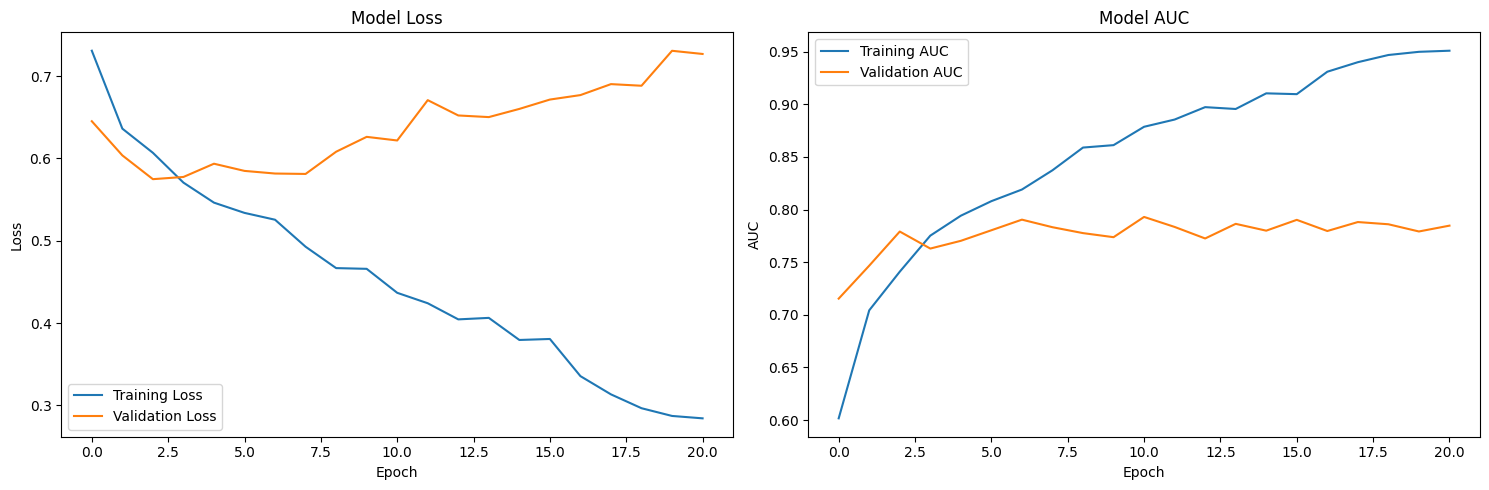

In [ ]:
import tensorflow as tf
from tensorflow.keras import layers, models, callbacks
import numpy as np
from sklearn.preprocessing import StandardScaler

def create_nn_model(input_dim, dropout_rate=0.3):
    """
    Creates a neural network with batch normalization, dropout, and residual connections
    """
    inputs = layers.Input(shape=(input_dim,))

    # Normalize inputs
    x = layers.BatchNormalization()(inputs)

    # First dense block
    x1 = layers.Dense(256)(x)
    x1 = layers.BatchNormalization()(x1)
    x1 = layers.PReLU()(x1)
    x1 = layers.Dropout(dropout_rate)(x1)

    # Second dense block with residual connection
    x2 = layers.Dense(256)(x1)
    x2 = layers.BatchNormalization()(x2)
    x2 = layers.PReLU()(x2)
    x2 = layers.Dropout(dropout_rate)(x2)
    x2 = layers.Add()([x1, x2])

    # Third dense block
    x3 = layers.Dense(128)(x2)
    x3 = layers.BatchNormalization()(x3)
    x3 = layers.PReLU()(x3)
    x3 = layers.Dropout(dropout_rate)(x3)

    # Final dense block
    x4 = layers.Dense(64)(x3)
    x4 = layers.BatchNormalization()(x4)
    x4 = layers.PReLU()(x4)
    x4 = layers.Dropout(dropout_rate/2)(x4)

    outputs = layers.Dense(1, activation='sigmoid')(x4)

    return models.Model(inputs=inputs, outputs=outputs)



# Create and compile model
model = create_nn_model(input_dim=X_train.shape[1])

# Compile with optimal settings
optimizer = tf.keras.optimizers.Adam(learning_rate=0.001)
model.compile(
    optimizer=optimizer,
    loss='binary_crossentropy',
    metrics=[
        'accuracy',
        tf.keras.metrics.AUC(name='auc'),
        tf.keras.metrics.Precision(name='precision'),
        tf.keras.metrics.Recall(name='recall')
    ]
)

# Calculate class weights for balanced training
total = len(y_train)
neg = np.sum(y_train == 0)
pos = np.sum(y_train == 1)
weight_for_0 = (1 / neg) * (total / 2.0)
weight_for_1 = (1 / pos) * (total / 2.0)
class_weight = {0: weight_for_0, 1: weight_for_1}

# Callbacks for better training
callbacks_list = [
    callbacks.EarlyStopping(
        monitor='val_auc',
        patience=10,
        restore_best_weights=True,
        mode='max'
    ),
    callbacks.ReduceLROnPlateau(
        monitor='val_auc',
        factor=0.5,
        patience=5,
        min_lr=1e-6,
        mode='max'
    ),
]

# Train the model
history = model.fit(
    X_train, y_train,
    validation_split=0.2,  # Using 20% of training data as validation
    epochs=100,
    batch_size=32,
    class_weight=class_weight,
    callbacks=callbacks_list,
    verbose=1
)

# Evaluate on test set
test_results = model.evaluate(X_test, y_test, verbose=0)
print("\nTest Set Results:")
for metric, value in zip(model.metrics_names, test_results):
    print(f"{metric}: {value:.4f}")

# If you want to plot the training history
def plot_training_history(history):
    import matplotlib.pyplot as plt

    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 5))

    ax1.plot(history.history['loss'], label='Training Loss')
    ax1.plot(history.history['val_loss'], label='Validation Loss')
    ax1.set_title('Model Loss')
    ax1.set_xlabel('Epoch')
    ax1.set_ylabel('Loss')
    ax1.legend()

    ax2.plot(history.history['auc'], label='Training AUC')
    ax2.plot(history.history['val_auc'], label='Validation AUC')
    ax2.set_title('Model AUC')
    ax2.set_xlabel('Epoch')
    ax2.set_ylabel('AUC')
    ax2.legend()

    plt.tight_layout()
    plt.show()

# Plot the training history
plot_training_history(history)

In [ ]:
# Reset index of DataFrames if necessary
X_train.reset_index(drop=True, inplace=True)
y_train.reset_index(drop=True, inplace=True)


In [ ]:
%%capture
%pip install tensorflow matplotlib scikit-learn
